# Analyze Relations

This notebook analyzes the occurence of different relations in the overall graph and in the subset of properties that connect mutually wikilinked entities. Futhermore, a list of the most common properties among the datasets is created, which is used later to filter the properties that used when creating embeddings and predicting relations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import os

## Load Datasets

The datasets that are used in this notebook are the two datasets containing connecting properties of mutually wikilinked entity pairs (both- and one-sided) and the dataset containing the overall relation counts in the graph.

In [2]:
# load data
mw_props_bs = pd.read_csv("data/exported_data/mutual_wikilinks_properties_both_sides.csv")
mw_props_os = pd.read_csv("data/exported_data/mutual_wikilinks_properties_one_side.csv")
property_counts = pd.read_csv("data/exported_data/property_counts.csv")

In [3]:
# sort data (index is preserved)
mw_props_bs = mw_props_bs.sort_values(["subject", "object", "predicate"])
mw_props_os = mw_props_os.sort_values(["subject", "object", "predicate"])

In [4]:
# count number of triples
print("Number of triples (properties from both sides dataset): ", len(mw_props_bs))
print("Number of triples (properties from one side only dataset): ", len(mw_props_os))

Number of triples (properties from both sides dataset):  610991
Number of triples (properties from one side only dataset):  2931750


In [5]:
mw_props_bs.head()

,subject,predicate,object
289429,http://dbpedia.org/resource/!!!,http://dbpedia.org/ontology/formerBandMember,http://dbpedia.org/resource/Jerry_Fuchs
408729,http://dbpedia.org/resource/!Oka_Tokat,http://dbpedia.org/ontology/related,http://dbpedia.org/resource/Oka_Tokat_(2012_TV...
250664,http://dbpedia.org/resource/!_(The_Song_Former...,http://dbpedia.org/ontology/subsequentWork,http://dbpedia.org/resource/Happiness_(Rotting...
431037,http://dbpedia.org/resource/!_(The_Song_Former...,http://dbpedia.org/ontology/previousWork,http://dbpedia.org/resource/Polyester_Girl
405505,http://dbpedia.org/resource/$pacely,http://dbpedia.org/ontology/associatedBand,http://dbpedia.org/resource/Nxwrth


In [6]:
mw_props_os.head()

,subject,predicate,object
572826,http://dbpedia.org/resource/!!!,http://dbpedia.org/ontology/genre,http://dbpedia.org/resource/Dance-punk
944188,http://dbpedia.org/resource/!!!,http://dbpedia.org/ontology/recordLabel,http://dbpedia.org/resource/Gold_Standard_Labo...
1288882,http://dbpedia.org/resource/!!!,http://dbpedia.org/ontology/formerBandMember,http://dbpedia.org/resource/Justin_Van_Der_Volgen
1762786,http://dbpedia.org/resource/!!!,http://dbpedia.org/ontology/bandMember,http://dbpedia.org/resource/Nic_Offer
2137719,http://dbpedia.org/resource/!!!,http://dbpedia.org/ontology/hometown,"http://dbpedia.org/resource/Sacramento,_Califo..."


In [7]:
property_counts.head()

,type,value.count
0,http://dbpedia.org/ontology/wikiPageWikiLink,256993708
1,http://dbpedia.org/ontology/team,3138832
2,http://dbpedia.org/ontology/careerStation,1716420
3,http://dbpedia.org/ontology/birthPlace,1486583
4,http://dbpedia.org/ontology/subdivision,1090641


## Counts and Distribution of Relations

The frequencies of relations are very different. Some properties appear very often while some are very rare.

In [8]:
property_counts.loc[:, "value.count"].describe()

count    6.270000e+02
mean     4.449857e+05
std      1.026342e+07
min      1.000000e+00
25%      2.980000e+02
50%      1.887000e+03
75%      1.357700e+04
max      2.569937e+08
Name: value.count, dtype: float64

The wikilinks relation is the most common relation. It is removed from the dataset, as it does not belong to the set of properties that need to be predicted. ...

In [9]:
property_counts = property_counts[property_counts["type"] != "http://dbpedia.org/ontology/wikiPageWikiLink"]

The plot below shows the relation counts for all relations, sorted by their count (highest count first).

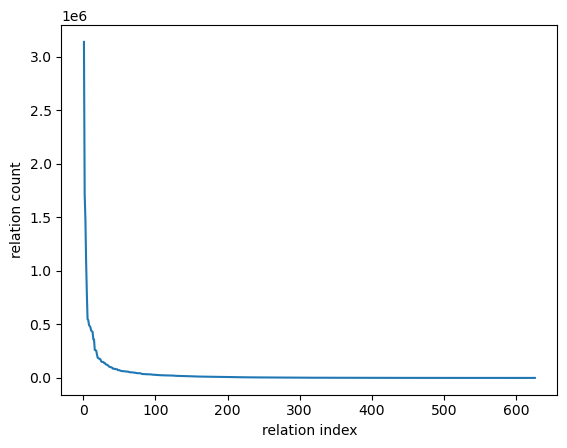

In [10]:
property_counts["value.count"].plot(
    kind="line",
    xlabel="relation index",
    ylabel="relation count"
)

plt.show()

The following code calculates the proportion of edges of each relation in comparison to the total count of edges. The most common edges make up for the majority of edges in the graph, which is also shown in the graph below.

In [11]:
total_edges_count = property_counts["value.count"].sum()
# calculate proportion of property counts (compared to total number of edges)
property_counts["proportion"] = property_counts["value.count"] / total_edges_count
# cumulative proportion (properties are ordered by count desceding)
property_counts["c_prop"] = property_counts["proportion"].cumsum()

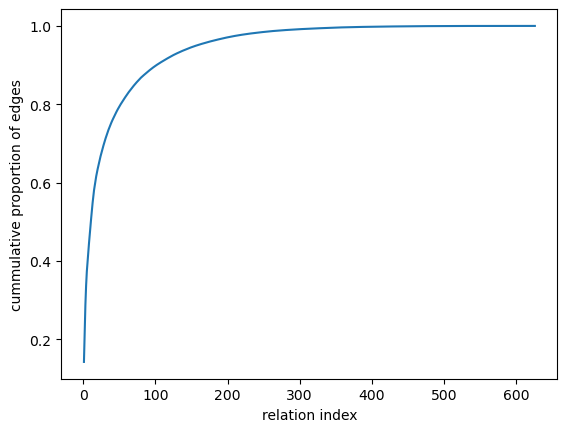

In [12]:
property_counts["c_prop"].plot(
    kind="line",
    xlabel="relation index",
    ylabel="cummulative proportion of edges"
)

plt.show()

The 300 most common properties make up over 99% of the edges in the graph (with wikilinks excluded).

In [13]:
property_counts.loc[[1, 10, 50, 100, 200, 300, 400, 500]]

,type,value.count,proportion,c_prop
1,http://dbpedia.org/ontology/team,3138832,0.142594,0.142594
10,http://dbpedia.org/ontology/occupation,472760,0.021477,0.489075
50,http://dbpedia.org/ontology/genus,72236,0.003282,0.794204
100,http://dbpedia.org/ontology/formerBandMember,28868,0.001311,0.898099
200,http://dbpedia.org/ontology/championInSingleMale,8500,0.000386,0.970852
300,http://dbpedia.org/ontology/saint,2214,0.000101,0.991672
400,http://dbpedia.org/ontology/coolingSystem,632,0.000029,0.997906
500,http://dbpedia.org/ontology/currentProduction,159,0.000007,0.999706


In [14]:
# calculate property counts of mutually wikilinked entities
property_counts_mw_bs = mw_props_bs["predicate"].value_counts().to_frame().reset_index()
property_counts_mw_os = mw_props_os["predicate"].value_counts().to_frame().reset_index()

In [15]:
property_counts_comparison = property_counts.copy()
property_counts_comparison = property_counts_comparison.drop(columns="c_prop")
property_counts_comparison = property_counts_comparison.rename(columns={"value.count": "count_all", "proportion": "proportion_all"})

# add count of properties between mutually wikilinked entities (both-sided)
property_counts_comparison = property_counts_comparison.merge(
    property_counts_mw_bs.rename(columns={"predicate": "type", "count": "count_mw_bs"}),
    on="type",
    how="outer"
)

# add count of properties between mutually wikilinked entities (one-sided)
property_counts_comparison = property_counts_comparison.merge(
    property_counts_mw_os.rename(columns={"predicate": "type", "count": "count_mw_os"}),
    on="type",
    how="outer"
)

property_counts_comparison["count_mw_bs"] = property_counts_comparison["count_mw_bs"].fillna(0)
total_mw_bs_edges = property_counts_comparison["count_mw_bs"].sum()
property_counts_comparison["proportion_mw_bs"] = property_counts_comparison["count_mw_bs"] / total_mw_bs_edges

property_counts_comparison["count_mw_os"] = property_counts_comparison["count_mw_os"].fillna(0)
total_mw_os_edges = property_counts_comparison["count_mw_os"].sum()
property_counts_comparison["proportion_mw_os"] = property_counts_comparison["count_mw_os"] / total_mw_os_edges

# sum up counts of one-sided and both sided datsets
property_counts_comparison["count_mw_all"] = property_counts_comparison["count_mw_bs"] + property_counts_comparison["count_mw_os"]
total_mw_all_edges = property_counts_comparison["count_mw_all"].sum()
property_counts_comparison["proportion_mw_all"] = property_counts_comparison["count_mw_all"] / total_mw_all_edges

# counts of all adges with substracted counts of edges in mutually wikilinked pairs
property_counts_comparison["count_all_without_mw"] = property_counts_comparison["count_all"] - property_counts_comparison["count_mw_all"]
total_edges_count_without_mw = property_counts_comparison["count_all_without_mw"].sum()
property_counts_comparison["proportion_all_without_mw"] = property_counts_comparison["count_all_without_mw"] / total_edges_count_without_mw

property_counts_comparison.head()

,type,count_all,proportion_all,count_mw_bs,count_mw_os,proportion_mw_bs,proportion_mw_os,count_mw_all,proportion_mw_all,count_all_without_mw,proportion_all_without_mw
0,http://dbpedia.org/ontology/team,3138832.0,0.142594,3058.0,139755.0,0.005005,0.047669,142813.0,0.040311,2996019.0,0.161573
1,http://dbpedia.org/ontology/careerStation,1716420.0,0.077975,0.0,0.0,0.000000,0.000000,0.0,0.000000,1716420.0,0.092565
2,http://dbpedia.org/ontology/birthPlace,1486583.0,0.067534,187.0,117173.0,0.000306,0.039967,117360.0,0.033127,1369223.0,0.073841
3,http://dbpedia.org/ontology/subdivision,1090641.0,0.049547,29053.0,263352.0,0.047551,0.089828,292405.0,0.082536,798236.0,0.043048
4,http://dbpedia.org/ontology/country,792700.0,0.036012,342.0,11078.0,0.000560,0.003779,11420.0,0.003223,781280.0,0.042134


In [16]:
print("number of properties without edges (wikilinked pairs with properties from both sides): ", (property_counts_comparison["count_mw_bs"] == 0).sum())
print("number of properties without edges (wikilinked pairs with properties from one side): ", (property_counts_comparison["count_mw_os"] == 0).sum())
print("number of properties without edges (all wikilinked pairs): ", (property_counts_comparison["count_mw_all"] == 0).sum())

number of properties without edges (wikilinked pairs with properties from both sides):  199
number of properties without edges (wikilinked pairs with properties from one side):  52
number of properties without edges (all wikilinked pairs):  48


In [17]:
property_counts_comparison.sort_values("proportion_mw_bs", ascending=False) \
    [["type", "proportion_all_without_mw", "proportion_mw_bs", "proportion_mw_os", "proportion_mw_all"]].head(10)

,type,proportion_all_without_mw,proportion_mw_bs,proportion_mw_os,proportion_mw_all
54,http://dbpedia.org/ontology/subsequentWork,0.000919,0.066012,0.002062,0.013091
56,http://dbpedia.org/ontology/previousWork,0.000882,0.066008,0.001948,0.012996
29,http://dbpedia.org/ontology/associatedMusicalA...,0.004021,0.057196,0.009986,0.018127
28,http://dbpedia.org/ontology/associatedBand,0.004020,0.057196,0.009992,0.018133
52,http://dbpedia.org/ontology/spouse,0.000908,0.055461,0.004682,0.013439
17,http://dbpedia.org/ontology/successor,0.011341,0.052052,0.004120,0.012386
16,http://dbpedia.org/ontology/predecessor,0.011936,0.051637,0.002340,0.010842
3,http://dbpedia.org/ontology/subdivision,0.043048,0.047551,0.089828,0.082536
87,http://dbpedia.org/ontology/sisterStation,0.000313,0.043891,0.000604,0.008069
626,http://www.w3.org/2000/01/rdf-schema#seeAlso,NaN,0.040768,0.013936,0.018564


In [18]:
property_counts_comparison.sort_values("proportion_mw_os", ascending=False) \
    [["type", "proportion_all", "proportion_mw_bs", "proportion_mw_os", "proportion_mw_all"]].head(10)

,type,proportion_all,proportion_mw_bs,proportion_mw_os,proportion_mw_all
5,http://dbpedia.org/ontology/starring,0.024909,0.004666,0.128976,0.107537
3,http://dbpedia.org/ontology/subdivision,0.049547,0.047551,0.089828,0.082536
0,http://dbpedia.org/ontology/team,0.142594,0.005005,0.047669,0.040311
15,http://dbpedia.org/ontology/writer,0.011870,0.002029,0.041146,0.034400
2,http://dbpedia.org/ontology/birthPlace,0.067534,0.000306,0.039967,0.033127
26,http://dbpedia.org/ontology/director,0.006775,0.002136,0.034154,0.028632
6,http://dbpedia.org/ontology/location,0.024560,0.001088,0.033478,0.027892
21,http://dbpedia.org/ontology/producer,0.008157,0.001049,0.024330,0.020315
49,http://dbpedia.org/ontology/genus,0.003282,0.000088,0.021688,0.017963
58,http://dbpedia.org/ontology/album,0.002716,0.000160,0.016897,0.014010


In [19]:
property_counts_comparison.sort_values("proportion_mw_all", ascending=False) \
    [["type", "proportion_all", "proportion_mw_bs", "proportion_mw_os", "proportion_mw_all"]].head(10)

,type,proportion_all,proportion_mw_bs,proportion_mw_os,proportion_mw_all
5,http://dbpedia.org/ontology/starring,0.024909,0.004666,0.128976,0.107537
3,http://dbpedia.org/ontology/subdivision,0.049547,0.047551,0.089828,0.082536
0,http://dbpedia.org/ontology/team,0.142594,0.005005,0.047669,0.040311
15,http://dbpedia.org/ontology/writer,0.011870,0.002029,0.041146,0.034400
2,http://dbpedia.org/ontology/birthPlace,0.067534,0.000306,0.039967,0.033127
26,http://dbpedia.org/ontology/director,0.006775,0.002136,0.034154,0.028632
6,http://dbpedia.org/ontology/location,0.024560,0.001088,0.033478,0.027892
21,http://dbpedia.org/ontology/producer,0.008157,0.001049,0.024330,0.020315
626,http://www.w3.org/2000/01/rdf-schema#seeAlso,NaN,0.040768,0.013936,0.018564
28,http://dbpedia.org/ontology/associatedBand,0.006305,0.057196,0.009992,0.018133


Correlation between counts...

In [20]:
property_counts_comparison[["count_all_without_mw", "count_mw_bs", "count_mw_os", "count_mw_all"]].corr()

,count_all_without_mw,count_mw_bs,count_mw_os,count_mw_all
count_all_without_mw,1.000000,0.097348,0.423442,0.417736
count_mw_bs,0.097348,1.000000,0.219872,0.398064
count_mw_os,0.423442,0.219872,1.000000,0.982432
count_mw_all,0.417736,0.398064,0.982432,1.000000


In [21]:
property_counts_comparison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632 entries, 0 to 631
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   type                       632 non-null    object 
 1   count_all                  626 non-null    float64
 2   proportion_all             626 non-null    float64
 3   count_mw_bs                632 non-null    float64
 4   count_mw_os                632 non-null    float64
 5   proportion_mw_bs           632 non-null    float64
 6   proportion_mw_os           632 non-null    float64
 7   count_mw_all               632 non-null    float64
 8   proportion_mw_all          632 non-null    float64
 9   count_all_without_mw       626 non-null    float64
 10  proportion_all_without_mw  626 non-null    float64
dtypes: float64(10), object(1)
memory usage: 54.4+ KB


In [22]:
property_counts_comparison[property_counts_comparison["count_all"].isna()]

,type,count_all,proportion_all,count_mw_bs,count_mw_os,proportion_mw_bs,proportion_mw_os,count_mw_all,proportion_mw_all,count_all_without_mw,proportion_all_without_mw
626,http://www.w3.org/2000/01/rdf-schema#seeAlso,NaN,NaN,24909.0,40858.0,0.040768,1.393639e-02,65767.0,1.856387e-02,NaN,NaN
627,http://www.w3.org/2002/07/owl#differentFrom,NaN,NaN,4090.0,3111.0,0.006694,1.061141e-03,7201.0,2.032607e-03,NaN,NaN
628,http://xmlns.com/foaf/0.1/depiction,NaN,NaN,36.0,22.0,0.000059,7.504050e-06,58.0,1.637150e-05,NaN,NaN
629,http://xmlns.com/foaf/0.1/logo,NaN,NaN,7.0,29.0,0.000011,9.891703e-06,36.0,1.016162e-05,NaN,NaN
630,http://purl.org/dc/elements/1.1/subject,NaN,NaN,2.0,185.0,0.000003,6.310224e-05,187.0,5.278399e-05,NaN,NaN
631,http://xmlns.com/foaf/0.1/page,NaN,NaN,0.0,1.0,0.000000,3.410932e-07,1.0,2.822673e-07,NaN,NaN


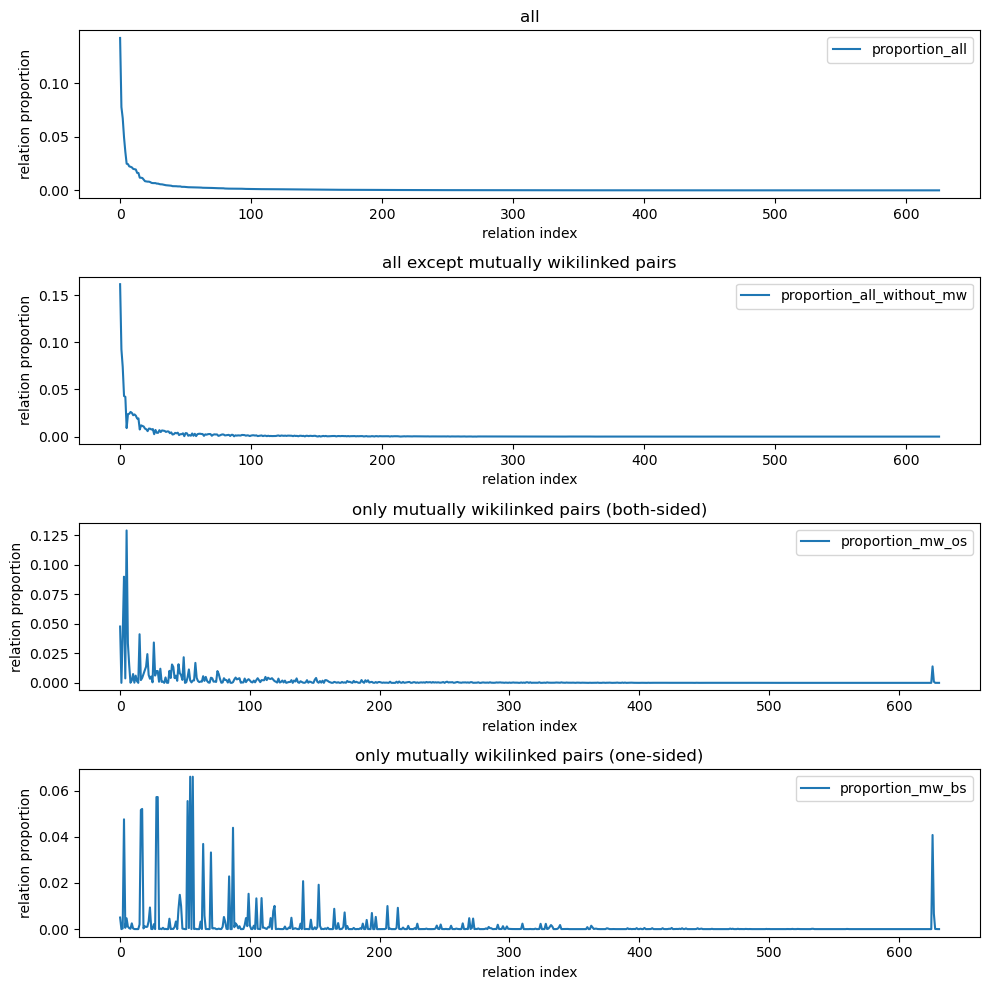

In [23]:
fig, axs = plt.subplots(nrows=4, figsize=(10, 10), tight_layout=True)

property_counts_comparison.plot(
    kind="line",
    y="proportion_all",
    xlabel="relation index",
    ylabel="relation proportion",
    title="all",
    ax=axs[0]
)

property_counts_comparison.plot(
    kind="line",
    y="proportion_all_without_mw",
    xlabel="relation index",
    ylabel="relation proportion",
    title="all except mutually wikilinked pairs",
    ax=axs[1]
)

property_counts_comparison.plot(
    kind="line",
    y="proportion_mw_os",
    xlabel="relation index",
    ylabel="relation proportion",
    title="only mutually wikilinked pairs (both-sided)",
    ax=axs[2]
)

property_counts_comparison.plot(
    kind="line",
    y="proportion_mw_bs",
    xlabel="relation index",
    ylabel="relation proportion",
    title="only mutually wikilinked pairs (one-sided)",
    ax=axs[3]
)

plt.show()

In [24]:
property_counts_comparison["count_all"].index.max()

631

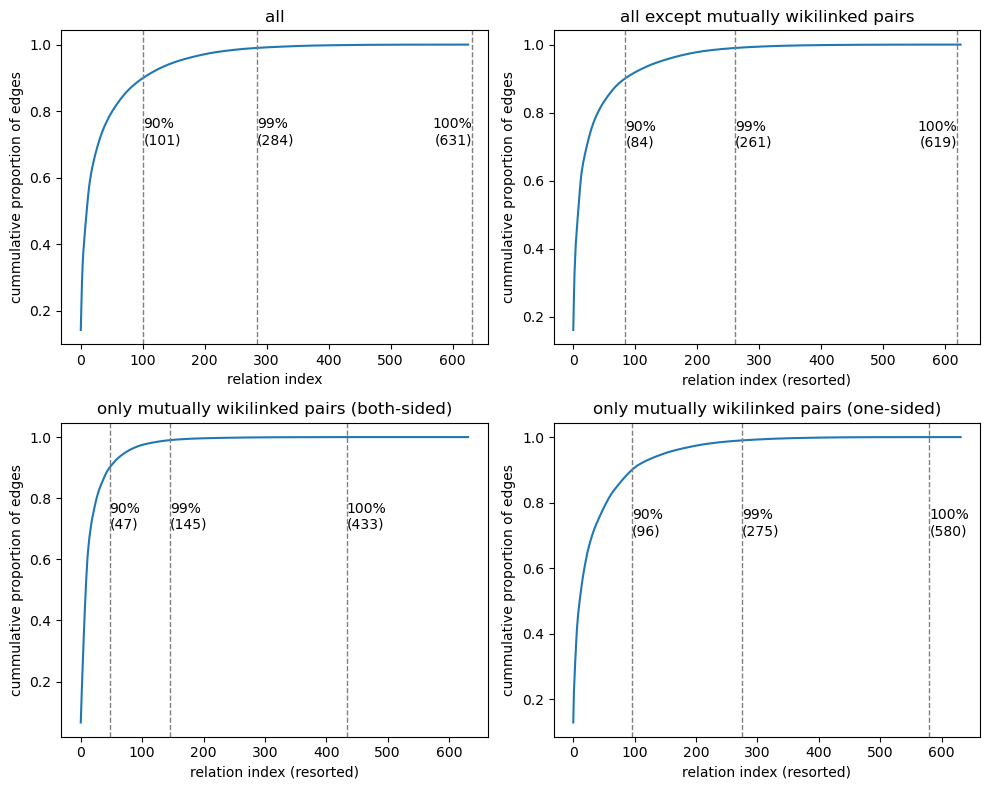

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), tight_layout=True)

property_counts_comparison["proportion_all"].sort_values(ascending=False).cumsum().plot(
    kind="line",
    xlabel="relation index",
    ylabel="cummulative proportion of edges",
    title="all",
    ax=axs[0, 0]
)
# add vertical lines at 90% and 99%
all_90_p = property_counts_comparison["proportion_all"].sort_values(ascending=False).cumsum()[
    property_counts_comparison["proportion_all"].sort_values(ascending=False).cumsum() > 0.90].index[0]
all_99_p = property_counts_comparison["proportion_all"].sort_values(ascending=False).cumsum()[
    property_counts_comparison["proportion_all"].sort_values(ascending=False).cumsum() > 0.99].index[0]
all_100_p = property_counts_comparison["count_all"].index.max()
axs[0, 0].axvline(all_90_p, linestyle="--", linewidth=1, color="gray")
axs[0, 0].text(all_90_p, 0.7, f"90%\n({all_90_p})")
axs[0, 0].axvline(all_99_p, linestyle="--", linewidth=1, color="gray")
axs[0, 0].text(all_99_p, 0.7, f"99%\n({all_99_p})")
axs[0, 0].axvline(all_100_p, linestyle="--", linewidth=1, color="gray")
axs[0, 0].text(all_100_p, 0.7, f"100%\n({all_100_p})", horizontalalignment="right")

property_counts_comparison["proportion_all_without_mw"].sort_values(ascending=False).reset_index(drop=True).cumsum().plot(
    kind="line",
    xlabel="relation index (resorted)",
    ylabel="cummulative proportion of edges",
    title="all except mutually wikilinked pairs",
    ax=axs[0, 1]
)
# add vertical lines at 90% and 99%
all_without_mw_90_p = property_counts_comparison["proportion_all_without_mw"].sort_values(ascending=False).reset_index(drop=True).cumsum()[
    property_counts_comparison["proportion_all_without_mw"].sort_values(ascending=False).reset_index(drop=True).cumsum() > 0.90].index[0]
all_without_mw_99_p = property_counts_comparison["proportion_all_without_mw"].sort_values(ascending=False).reset_index(drop=True).cumsum()[
    property_counts_comparison["proportion_all_without_mw"].sort_values(ascending=False).reset_index(drop=True).cumsum() > 0.99].index[0]
all_without_mw_100_p = property_counts_comparison["count_all_without_mw"].sort_values(ascending=False).reset_index(drop=True)[
    property_counts_comparison["count_all_without_mw"].sort_values(ascending=False).reset_index(drop=True) == 0].index[0]
axs[0, 1].axvline(all_without_mw_90_p, linestyle="--", linewidth=1, color="gray")
axs[0, 1].text(all_without_mw_90_p, 0.7, f"90%\n({all_without_mw_90_p})")
axs[0, 1].axvline(all_without_mw_99_p, linestyle="--", linewidth=1, color="gray")
axs[0, 1].text(all_without_mw_99_p, 0.7, f"99%\n({all_without_mw_99_p})")
axs[0, 1].axvline(all_without_mw_100_p, linestyle="--", linewidth=1, color="gray")
axs[0, 1].text(all_without_mw_100_p, 0.7, f"100%\n({all_without_mw_100_p})", horizontalalignment="right")

property_counts_comparison["proportion_mw_bs"].sort_values(ascending=False).reset_index(drop=True).cumsum().plot(
    kind="line",
    xlabel="relation index (resorted)",
    ylabel="cummulative proportion of edges",
    title="only mutually wikilinked pairs (both-sided)",
    ax=axs[1, 0]
)
# add vertical lines at 90% and 99%
mw_bs_90_p = property_counts_comparison["proportion_mw_bs"].sort_values(ascending=False).reset_index(drop=True).cumsum()[
    property_counts_comparison["proportion_mw_bs"].sort_values(ascending=False).reset_index(drop=True).cumsum() > 0.90].index[0]
mw_bs_99_p = property_counts_comparison["proportion_mw_bs"].sort_values(ascending=False).reset_index(drop=True).cumsum()[
    property_counts_comparison["proportion_mw_bs"].sort_values(ascending=False).reset_index(drop=True).cumsum() > 0.99].index[0]
mw_bs_100_p = property_counts_comparison["count_mw_bs"].sort_values(ascending=False).reset_index(drop=True)[
    property_counts_comparison["count_mw_bs"].sort_values(ascending=False).reset_index(drop=True) == 0].index[0]
axs[1, 0].axvline(mw_bs_90_p, linestyle="--", linewidth=1, color="gray")
axs[1, 0].text(mw_bs_90_p, 0.7, f"90%\n({mw_bs_90_p})")
axs[1, 0].axvline(mw_bs_99_p, linestyle="--", linewidth=1, color="gray")
axs[1, 0].text(mw_bs_99_p, 0.7, f"99%\n({mw_bs_99_p})")
axs[1, 0].axvline(mw_bs_100_p, linestyle="--", linewidth=1, color="gray")
axs[1, 0].text(mw_bs_100_p, 0.7, f"100%\n({mw_bs_100_p})")

property_counts_comparison["proportion_mw_os"].sort_values(ascending=False).reset_index(drop=True).cumsum().plot(
    kind="line",
    xlabel="relation index (resorted)",
    ylabel="cummulative proportion of edges",
    title="only mutually wikilinked pairs (one-sided)",
    ax=axs[1, 1]
)
# add vertical lines at 90% and 99%
mw_os_90_p = property_counts_comparison["proportion_mw_os"].sort_values(ascending=False).reset_index(drop=True).cumsum()[
    property_counts_comparison["proportion_mw_os"].sort_values(ascending=False).reset_index(drop=True).cumsum() > 0.90].index[0]
mw_os_99_p = property_counts_comparison["proportion_mw_os"].sort_values(ascending=False).reset_index(drop=True).cumsum()[
    property_counts_comparison["proportion_mw_os"].sort_values(ascending=False).reset_index(drop=True).cumsum() > 0.99].index[0]
mw_os_100_p = property_counts_comparison["count_mw_os"].sort_values(ascending=False).reset_index(drop=True)[
    property_counts_comparison["count_mw_os"].sort_values(ascending=False).reset_index(drop=True) == 0].index[0]
axs[1, 1].axvline(mw_os_90_p, linestyle="--", linewidth=1, color="gray")
axs[1, 1].text(mw_os_90_p, 0.7, f"90%\n({mw_os_90_p})")
axs[1, 1].axvline(mw_os_99_p, linestyle="--", linewidth=1, color="gray")
axs[1, 1].text(mw_os_99_p, 0.7, f"99%\n({mw_os_99_p})")
axs[1, 1].axvline(mw_os_100_p, linestyle="--", linewidth=1, color="gray")
axs[1, 1].text(mw_os_100_p, 0.7, f"100%\n({mw_os_100_p})")

plt.show()

## Filtering Relations

To increse the performance of the embedding generation and link prediction (in terms of training time and prediction capabilites) the properties are reduced to properties that appear somewhat often in the data.

In [26]:
# get index for relations that make up 99% of edges (per dataset)
all_without_mw_filtered_props = property_counts_comparison["proportion_all_without_mw"].sort_values(ascending=False).iloc[:all_without_mw_99_p].index
mw_bs_filtered_props = property_counts_comparison["proportion_mw_bs"].sort_values(ascending=False).iloc[:mw_bs_99_p].index
mw_os_filtered_props = property_counts_comparison["proportion_mw_os"].sort_values(ascending=False).iloc[:mw_os_99_p].index
# union of all three filtered property sets
union_filtered_props = np.union1d(np.union1d(all_without_mw_filtered_props, mw_bs_filtered_props), mw_os_filtered_props)
# union of mutually wikilinked datasets
union_filtered_props_mw_only = np.union1d(mw_bs_filtered_props, mw_os_filtered_props)

print("number of filtered properties (all without mutual wikilnks): ", len(all_without_mw_filtered_props))
print("number of filtered properties (mutual wikilinks both-sided): ", len(mw_bs_filtered_props))
print("number of filtered properties (mutual wikilinks one-sided): ", len(mw_os_filtered_props))
print("number of filtered properties (union): ", len(union_filtered_props))
print("number of filtered properties (union mutully wikilinked datasets only): ", len(union_filtered_props_mw_only))

number of filtered properties (all without mutual wikilnks):  261
number of filtered properties (mutual wikilinks both-sided):  145
number of filtered properties (mutual wikilinks one-sided):  275
number of filtered properties (union):  355
number of filtered properties (union mutully wikilinked datasets only):  305


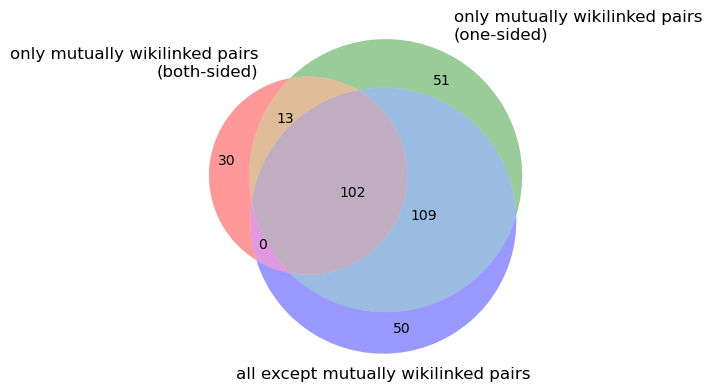

In [27]:
intersect_mw_bs_all_without_mw = np.intersect1d(mw_bs_filtered_props, all_without_mw_filtered_props)
intersect_mw_os_all_without_mw = np.intersect1d(mw_os_filtered_props, all_without_mw_filtered_props)
intersect_mw_bs_mw_os = np.intersect1d(mw_bs_filtered_props, mw_os_filtered_props)
intersect_all = np.intersect1d(np.intersect1d(intersect_mw_bs_all_without_mw, intersect_mw_os_all_without_mw), intersect_mw_bs_mw_os)

venn3(
    subsets=(
        len(mw_bs_filtered_props) - len(intersect_mw_bs_all_without_mw) - len(intersect_mw_bs_mw_os) + len(intersect_all),
        len(mw_os_filtered_props) - len(intersect_mw_os_all_without_mw) - len(intersect_mw_bs_mw_os) + len(intersect_all),
        len(intersect_mw_bs_mw_os) - len(intersect_all),
        len(all_without_mw_filtered_props) - len(intersect_mw_bs_all_without_mw) - len(intersect_mw_os_all_without_mw) + len(intersect_all),
        len(intersect_mw_bs_all_without_mw) - len(intersect_all),
        len(intersect_mw_os_all_without_mw) - len(intersect_all),
        len(intersect_all)
    ),
    set_labels=(
        "only mutually wikilinked pairs\n(both-sided)",
        "only mutually wikilinked pairs\n(one-sided)",
        "all except mutually wikilinked pairs"
    )
)

plt.show()

In [28]:
union_filtered_props_mw_only_strs = property_counts_comparison.loc[union_filtered_props_mw_only]["type"].rename("filtered_property_types")

In [29]:
# proportion of properties per dataset that are part of the union of the filtered property sets

n_mw_prop_types_bs = len(mw_props_bs['predicate'].unique())
n_mw_prop_types_bs_filtered = len(np.intersect1d(mw_props_bs['predicate'].unique(), union_filtered_props_mw_only_strs))
n_mw_prop_types_os = len(mw_props_os['predicate'].unique())
n_mw_prop_types_os_filtered = len(np.intersect1d(mw_props_os['predicate'].unique(), union_filtered_props_mw_only_strs))

print("\t\tnumber of unique properties\n\t\tbefore filtering\tafter filtering")
print(f"both-sided\t{n_mw_prop_types_bs}\t\t\t{n_mw_prop_types_bs_filtered} ({round(n_mw_prop_types_bs_filtered / n_mw_prop_types_bs, 3)})")
print(f"one-sided\t{n_mw_prop_types_os}\t\t\t{n_mw_prop_types_os_filtered} ({round(n_mw_prop_types_os_filtered / n_mw_prop_types_os, 3)})")

		number of unique properties
		before filtering	after filtering
both-sided	433			281 (0.649)
one-sided	580			305 (0.526)


The filtered set of relations is exported. This file is then used in other stages of the thesis, e.g. when creating embeddings to filter the properies.

In [30]:
# export filtered relations
results_dir_filepath = "data/processed_data/"
if not os.path.isdir(results_dir_filepath):
    os.mkdir(results_dir_filepath)
union_filtered_props_mw_only_strs.to_csv(results_dir_filepath+"filtered_property_types.csv", index=False)